In [63]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os 
import sys
import sympy as sym
sys.path.append('/home/arnau/documents/ETHZ/Semester_Project_Master_Thesis/pyOPALTools')
from opal.parser.H5Parser import H5Parser
from decimal import Decimal
from scipy.signal import find_peaks
import plotly.express as px
import plotly

########################
for_report = False
# generic_fn = 'fullBeamline_ILS1=0:350:50_ILS2=0:350:50_ILS3=0:350:50/fullBeamline_ILS1=#_ILS2=#_ILS3=#/fullBeamline'
generic_fn = 'tests/fullBeamlineIndividual#/fullBeamline'

fs = 14
########################

if not for_report:
    from datetime import date
    today = date.today()
#     footnote = 'A.Albà, ' + str(today) + '\ndir: /' + (os.path.split(os.getcwd()))[1]
    footnote = 'A.Albà, ' + str(today)
    print(footnote)
    generic_title = 'Linacs and solenoids'
else:
    generic_title = " "
    footnote = " "

A.Albà, 2019-12-05


# Definitions

## Functions

In [2]:
def get_ps_xy( fn, step, qx, qy, boolprint = False ):    
    ''' Get data to plot from file fn and given step. qx and qy are arrays of strings with data to plot
    eg ['z'], ['x', 'E'] '''
    h5p = H5Parser()
    h5p.parse( fn, boolprint )
    x = []
    for qi in qx:
        x.append( h5p.getStepDataset( dsetName = qi, step = step) )
    y  = []
    for qi in qy:
        if qi == 'E':
            # Get E
            E = []
            px = h5p.getStepDataset( dsetName = 'px', step = step)
            py = h5p.getStepDataset( dsetName = 'py', step = step)
            pz = h5p.getStepDataset( dsetName = 'pz', step = step)
            for i, pxi in enumerate(px):
                p2 = px[i]**2 + py[i]**2 + pz[i]**2  
                E.append( np.sqrt( 1 + p2 )*.511 )
            y.append( E )
        else:
            y.append( h5p.getStepDataset( dsetName = qi, step = step) )
    
    spos = h5p.getStepAttribute('SPOS', step = step)
    nSteps = h5p.getNSteps()
    if ( boolprint ):
        print(h5p.getStepDatasets(step = step))
        print('spos = ',spos)
    if len(x) == 1:
        x = x[0]
    if len(y) == 1:
        y = y[0]

    
    return [ x, y, spos[0], nSteps ]

def FT( x, y, cut = [], nbins = 100, boolplot = False, prominence = 0.0 ):
    # Sort
    idx   = np.argsort(x)
    x = np.array( x )[idx]
    y = np.array( y )[idx]
    # Trim data
    if len(cut) != 0:
        i = 0
        while( x[i] < cut[0] ):
            i += 1
        j = len(x) - 1   
        while( x[j] > cut[1] ):
            j -= 1    
        x = x[ i : j ]
        y = y[ i : j ]
    # Flatten data
    m = ( y[-1] - y[0] ) / ( x[-1] - x[0] )
    #y = [ y[i] - m * xi for i, xi in enumerate(x) ]
    y -= np.average(y)
    # Get data organised in bins
    x_bins = np.linspace( np.min(x), np.max(x), nbins )
    digitized = np.digitize( x, x_bins ) - 1 
    y = np.array(y)
    E_means = [ y[digitized == i].mean() for i in range(nbins) ]
    # Plot
    if boolplot:
        fig, ax = plt.subplots(1,2)
        fig.set_size_inches(15, 5)
        ax[0].scatter( x_bins, E_means, marker = '.', color = 'k' )
        ax[0].grid()
        ax[0].tick_params( axis = 'both', labelsize = fs)
        if len(cut) != 0:
            ax[0].set_xlim( left = cut[0], right = cut[1]  )
    # Fourier transform        
    dist = np.max(x) - np.min(x)
    amp = np.fft.fft(E_means)[:nbins//2] / nbins
    freq = np.arange( nbins//2 ) / dist
    # Find peak frequencies
    peaks, _ = find_peaks( np.abs(amp), prominence = prominence )
    amp_peaks = np.abs(amp)[peaks]
    peaks = peaks / dist
    if boolplot:
        for peak in peaks:
            ax[1].axvline( peak, color = 'r' )
        ax[1].plot( freq, np.abs(amp) )
        ax[1].grid()
        ax[1].tick_params( axis = 'both', labelsize = fs)
        ax[1].set_xlabel('freq [$m^-1$]')
        print('peaks at ', peaks)
    
    return [ freq, amp, peaks, amp_peaks ]

def fillIn( fn, rep = [], show = False ):
    newfn = fn
    for r in rep:
        newfn = newfn.replace( '#', str(int(r)), 1 )
    if show:
        print(newfn)
    return newfn

def getStats( fn, show = False ):
    fn = fn + '.stat'
    text = open( fn, 'r' )
    names = []
    units = []
    for line in text:
        if 'name' in line:
            ind1 = line.find('=')
            ind2 = line.find(',')
            name = line[ind1+1:ind2]
        if 'units' in line:
            ind1 = line.find('=')
            ind2 = line.find(',')
            unit = line[ind1+1:ind2]
            if unit == '1':
                unit = ' '
            names.append( str(name) + ' [' + str(unit) + ']' )
    for i,_ in enumerate(names):
        if show:
            print( i, names[i])
    return pd.read_csv( filepath_or_buffer = fn,
                       skiprows = 279, sep = '\s+', names = names)

def plotStats( stat, ax1, xax, ylax, yrax, colorL = 'r', colorR = 'b', show = False ):
    names = stat.columns
    x = np.array( stat[names[xax]] )
    labxax = names[xax] 
    # Left axis y
    y = np.array( stat[names[ylax]] )
    labyax = names[ylax]
    if 'emit' in labyax:
        y = np.log(y)
        labyax = 'log ' + labyax
        
    ax1.plot( x, y, color = colorL )
    ax1.set_xlabel(labxax, fontsize = fs)
    ax1.set_ylabel(labyax, fontsize = fs, color = colorL)
    ax1.tick_params( axis = 'y', labelsize = fs, labelcolor = colorL )
    ax1.tick_params( axis = 'x', labelsize = fs, labelcolor = 'k')

    plt.text( .75, -.25, footnote, transform=ax1.transAxes )
    plt.grid()
    # plt.xlim(left=.1)
    
    # Right axis y
    if yrax != -1:
        y = np.array( stat[names[yrax]] )
        labyax = names[yrax] 
        if 'emit' in labyax:
            y = np.log(y)
            labyax = 'log ' + labyax
        ax2 = ax1.twinx()
        ax2.plot( x, y, color = colorR )
        ax2.set_ylabel(labyax, fontsize = fs, color = colorR)
        ax2.tick_params( axis = 'y', labelsize = fs, labelcolor = colorR )
        if show:
            print(xax, names[xax], ', ',ylax, names[ylax], ', ', yrax, names[yrax])
    elif show:
        print(xax, names[xax], ', ',ylax, names[ylax])
        
def accept(x,y, limx = 0, cutoffy = 1, cutoffSlope = 0):
    x = np.array(x)
    y = np.array(y)
    if y[-1] > cutoffy:
        return 0
    while x[0] < limx:
        x = x[1:]
        y = y[1:]
    slope = (y[-1]-y[0]) / (x[-1]-x[0])
    return slope < cutoffSlope

def combine( ranges ):
    total_combs = []
    for r in ranges:
        n = len(r)
        n2 = np.power(n,2)
        combs = np.zeros( [np.power(n,3),3] )
        for i, c in enumerate(combs):
            combs[i][0] = int(r[int(i/n2)])
            combs[i][1] = r[int(i/n)%n]
            combs[i][2] = r[i%n]
        total_combs.append(combs)
    return np.concatenate(total_combs)
            
# combs = combine( [ [0,50,100,150,200], [250,300,350] ] )
combs = combine( [ [0,50,100,150,200], [250,300] ] )


def getMomentsMatrix( stat, pos, show = False ):
    # Get the row just before pos
    realRow = None
    for i, row in stat.iterrows():
        realPos = row['s [m]'] -  row['mean_s [m]']
        if realPos > pos:
            break
        realRow = row
    if realPos < pos:
        print('given position is out of range.')
        return []
    if show:
        print( 'Chosen row ', i-1 )
        print( realRow )
    
    
    M = np.zeros([4,4])
    for i, axis in enumerate(['x','y']):
    # Get necessary quantities
        rms = 'rms_# [m]'.replace( '#', axis )
        prms = 'rms_p# [ ]'.replace( '#', axis )
        cov = '#p# [ ]'.replace( '#', axis )

        rms = row[rms]
        prms = row[prms]
        cov = row[cov]

        # Calculate
        M[2*i,2*i] = rms
        M[2*i,2*i+1] = cov
        M[2*i+1,2*i] = M[2*i,2*i+1]
        M[2*i+1,2*i+1] = prms
    
    return M


# Plot stat file

tests/fullBeamlineIndividual3/fullBeamline


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


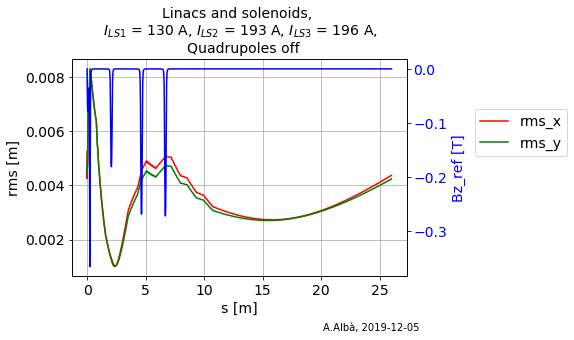

In [214]:
fn = fillIn( generic_fn, rep = [3], show = True)
stat = getStats( fn, show = False )

fig, ax1 = plt.subplots()
plotStats( stat, ax1, 1, 5, 35, 'r', 'b', show = False)
x = np.array(stat['s [m]'])
y = np.array(stat['rms_y [m]'])
ax1.plot( x, y, color = 'g' )
ax1.set_ylabel( 'rms [m]', color = 'k', fontsize = fs )
ax1.tick_params( axis = 'y', labelsize = fs, labelcolor = 'k' )
ax1.legend( ['rms_x', 'rms_y'], bbox_to_anchor = [1.5, .8], fontsize = fs )
plt.title(generic_title + ', \n $I_{LS1}$ = 130 A, $I_{LS2}$ = 193 A, $I_{LS3}$ = 196 A, \n  Quadrupoles off', fontsize = fs)
# ax1.axvline(quad_pos[0], linewidth = 2, color = 'y')
# ax1.text(quad_pos[0], 6e-3, 'First undulator (off)', fontsize  =fs)
plt.savefig('plots/rms_x.eps', bbox_inches='tight')
plt.show()

1 s [m] ,  16 mean_s [m] ,  0 t [ns]


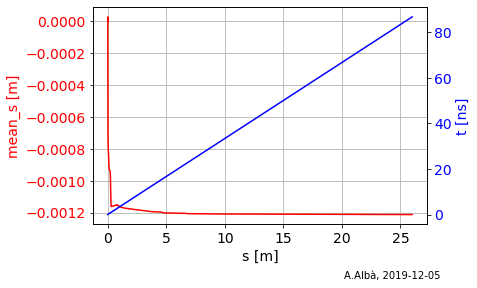

In [5]:

fig, ax1 = plt.subplots()
plotStats( stat, ax1, 1, 16, 0, 'r', 'b', show = True )

plt.show()

## Compare simulations

In [ ]:
stats = []
for c in combs:           
    fn = fillIn( generic_fn, rep = c, show = False)
    stat = getStats( fn, show = False )
    ILS = str(c)
    stat['ILS'] = [ILS]*stat.shape[0]
    stats.append(stat)
stats = pd.concat(stats)
names = stats.columns
fig = px.scatter(stats, x = names[1], y = names[5], color="ILS")
plotly.offline.plot(fig, filename = 'plots/all.html', auto_open=False)
fig.show()

In [ ]:
stats = []
for c in combs:           
    fn = fillIn( generic_fn, rep = c, show = False)
    stat = getStats( fn, show = False )
    if not accept(stat['s [m]'], stat['rms_x [m]'], cutoffy = 5e-3, limx = 10):
        continue
    ILS = str(c)
    stat['ILS'] = [ILS]*stat.shape[0]
    stats.append(stat)
stats = pd.concat(stats)

fig = px.scatter(stats, x = 's [m]', y = 'rms_x [m]', color="ILS")
plotly.offline.plot(fig, filename = 'plots/cutoff.html', auto_open=False)
fig.show()

# Quadrupoles

## Positions and Transfer matrices

In [359]:
L6 = 10.36  # meters
first_quad_pos = L6 + ( 121.07 + 88.95 ) * 1e-2
drifts = [ .247, .383, .7075 ]  # Number of drift should be Nq-1, where Nq is number of quads
# drifts = [ .247 ]  # Number of drift should be Nq-1, where Nq is number of quads
finalPos = 25.7  # meters
drifts.append( finalPos - first_quad_pos - np.sum(drifts) )

f1m, f2m, f3m, f4m = sym.symbols('f1m, f2m, f3m, f4m', real = True)  # f1m = 1 / f1
quad_syms = [f1m, f2m, f3m, f4m]

quad_pos = []
MSyms = []
for i, di in enumerate(drifts):
    # Quad position
    quad_pos.append( first_quad_pos + np.sum(drifts[:i])  )
    # Thin quadrupole symbolic x-matrix
    MSyms.append( np.diag(np.ones(4)) + np.diag([ -quad_syms[i], 0, quad_syms[i] ], k = -1) ) 
    # Drift matrix after quadrupole
    MSyms.append( np.diag(np.ones(4)) + np.diag([di, 0, di], k = 1)  )
        
for M in MSyms:
    print( M, '\n\n')
    
print('quads at ', quad_pos)

[[1.0 0.0 0.0 0.0]
 [-f1m 1.0 0.0 0.0]
 [0.0 0.0 1.0 0.0]
 [0.0 0.0 f1m 1.0]] 


[[1.    0.247 0.    0.   ]
 [0.    1.    0.    0.   ]
 [0.    0.    1.    0.247]
 [0.    0.    0.    1.   ]] 


[[1.0 0.0 0.0 0.0]
 [-f2m 1.0 0.0 0.0]
 [0.0 0.0 1.0 0.0]
 [0.0 0.0 f2m 1.0]] 


[[1.    0.383 0.    0.   ]
 [0.    1.    0.    0.   ]
 [0.    0.    1.    0.383]
 [0.    0.    0.    1.   ]] 


[[1.0 0.0 0.0 0.0]
 [-f3m 1.0 0.0 0.0]
 [0.0 0.0 1.0 0.0]
 [0.0 0.0 f3m 1.0]] 


[[1.     0.7075 0.     0.    ]
 [0.     1.     0.     0.    ]
 [0.     0.     1.     0.7075]
 [0.     0.     0.     1.    ]] 


[[1.0 0.0 0.0 0.0]
 [-f4m 1.0 0.0 0.0]
 [0.0 0.0 1.0 0.0]
 [0.0 0.0 f4m 1.0]] 


[[ 1.     11.9023  0.      0.    ]
 [ 0.      1.      0.      0.    ]
 [ 0.      0.      1.     11.9023]
 [ 0.      0.      0.      1.    ]] 


quads at  [12.4602, 12.7072, 13.090200000000001, 13.7977]


## Get moments

In [360]:
fn = fillIn( generic_fn, rep = [3], show = True)
stat = getStats( fn, show = False )
sig = getMomentsMatrix( stat, quad_pos[0],show = False )
print(sig)


tests/fullBeamlineIndividual3/fullBeamline
[[ 0.00295073 -0.41772225  0.          0.        ]
 [-0.41772225  0.04042705  0.          0.        ]
 [ 0.          0.          0.00285874 -0.36340097]
 [ 0.          0.         -0.36340097  0.03645978]]


## Define  symbolic problem

In [379]:
MSym = np.linalg.multi_dot(MSyms)
sigFinal = np.linalg.multi_dot([MSym, sig, MSym.T])
diff = sig - sigFinal
dx2 = diff[0,0]
dxpx = diff[1,0]
dpx2 = diff[1,1]
dy2 = diff[2,2]
dypy = diff[3,2]
dpy2 = diff[3,3]
x = np.linspace(-1.136, 1.136, 15)
best = np.zeros(4)
minBest = 10
for i in x:
    for j in x:
        for k in x:
            for l in x:
                a = dx2
                a = a.subs(f1m, i)
                a = a.subs(f2m, j)
                a = a.subs(f3m, k)
                a = float( a.subs(f4m, l) )
                b = dy2
                b = b.subs(f1m, i)
                b = b.subs(f2m, j)
                b = b.subs(f3m, k)
                b = float( b.subs(f4m, l) )
                val =  np.sqrt( a**2 + b**2 )
                if val < minBest:
                    minBest = val
                    print(val)
                    best = np.array([i,j,k,l])
print(best)
# sols = sym.solve( [dy2], [f1m, f2m, f3m, f4m], dict = True )
# sols

7.583780029329112
4.017495554301002
1.734120982922633
1.2872644098885548
[-1.136      -1.136      -1.136       0.81142857]


In [381]:
a = dx2
a = a.subs(f1m, best[0])
a = a.subs(f2m, best[1])
a = a.subs(f3m, best[2])
a = float( a.subs(f4m, best[3]) )
b = dy2
b = b.subs(f1m, best[0])
b = b.subs(f2m, best[1])
b = b.subs(f3m, best[2])
b = float( b.subs(f4m, best[3]) )
val =  np.sqrt( a**2 + b**2 )
print(a,b)

# print(len(sols))
# su = 0  # Solution to use
# quad_fs = np.zeros(3)
# quad_fs[3] = 1.  # Choose f3m freely

# quad_fs[0] = sols[su][f1m].subs( f4m, quad_fs[2] )
# quad_fs[1] = sols[su][f2m].subs( f4m, quad_fs[2] )
# quad_fs[2] = sols[su][f3m].subs( f4m, quad_fs[2] )

# # x = np.linspace(-1.136, 1.136)
# # y = [sols[su][f1m].subs( f3m, xi ) for xi in x ]
# # plt.plot(x, y)
# # y = [sols[su][f2m].subs( f3m, xi ) for xi in x ]
# # plt.plot(x, y)
# # plt.grid()
# # plt.show()
# print(quad_fs)

# # Get Ks. Note that k_iL = 1/f_i = f_im
# Lquad = .11
# quad_Ks = quad_fs / Lquad
# print(quad_Ks)

0.10355706390746378 1.2830922006935412


## Make matrices

In [307]:
Ms = []
for i, di in enumerate(drifts):
    # Thin quadrupole matrix
    Ms.append( np.diag(np.ones(4)) + np.diag([ -quad_fs[i], 0, quad_fs[i] ], k = -1) )
    # Drift matrix after quadrupole
    Ms.append( np.diag(np.ones(4)) + np.diag([di, 0, di], k = 1)  )

for M in Ms:
    print( M, '\n\n')
    
M = np.linalg.multi_dot(Ms)
print('total M =\n' , M, '\ntotal Mt =\n' ,M.T )
sigFinal = np.linalg.multi_dot([M, sig,  M.T])
print( '\n\nsigXFinal =\n ', sigFinal, '\n\nsigX = \n', sig)


[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]] 


[[1.    0.247 0.    0.   ]
 [0.    1.    0.    0.   ]
 [0.    0.    1.    0.247]
 [0.    0.    0.    1.   ]] 


[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]] 


[[1.    0.383 0.    0.   ]
 [0.    1.    0.    0.   ]
 [0.    0.    1.    0.383]
 [0.    0.    0.    1.   ]] 


[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]] 


[[ 1.     12.6098  0.      0.    ]
 [ 0.      1.      0.      0.    ]
 [ 0.      0.      1.     12.6098]
 [ 0.      0.      0.      1.    ]] 


total M =
 [[ 1.     13.2398  0.      0.    ]
 [ 0.      1.      0.      0.    ]
 [ 0.      0.      1.     13.2398]
 [ 0.      0.      0.      1.    ]] 
total Mt =
 [[ 1.      0.      0.      0.    ]
 [13.2398  1.      0.      0.    ]
 [ 0.      0.      1.      0.    ]
 [ 0.      0.     13.2398  1.    ]]


sigXFinal =
  [[-3.97161705  0.11752377  0.          0.        ]
 [ 0.11752377  0.04042705  0.          0.        ]
 [ 0.          0